## Step 1)

Import the necessary packages and read the data file. 


In [13]:
# The import command allows us to call on various libraries
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
from geopy.geocoders import MapBox
import matplotlib.pyplot as plt
# You need this to query mapbox
api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2twY3g4aXloMWFlcDJzbXN3aG95aG5uZiJ9.mFiJt0MIfL1MiJ2rB2xhKQ"

if api_key == "":
    print('Please enter your API key to continue!')
else:
    BC_Data = pd.read_csv('Data/BC_Data_10yrs.csv',index_col='id_victim',parse_dates=['date'])
BC_Data.head()

,date,first_name,last_name,middle_name,alias_nickname,age,gender,race,prov,department,...,injured_officer,excited_delirium,mentral_distress_disorder,substance_abuse,charge_type,charges,officers involved,Check,Inquest date,extra_source
id_victim,,,,,,,,,,,,,,,,,,,,,
MR_225,2021-05-20,Unspecified,Unspecified,NaN,NaN,NaN,Female,Unspecified,BC,RCMP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validated,NaN,NaN
1809_KCC,2021-05-12,Unspecified,Unspecified,NaN,NaN,NaN,Unspecified,Unspecified,BC,RCMP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validated,NaN,NaN
MR_221,2021-05-01,Unspecified,NaN,NaN,NaN,NaN,Female,Unspecified,BC,Vancouver Police Department,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validated,NaN,NaN
MR_210,2021-02-27,Julian,Jones,NaN,NaN,28.0,Male,Indigenous,BC,RCMP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validated,NaN,NaN
MR_195,2021-01-05,Unspecified,NaN,NaN,NaN,37.0,Male,Unspecified,BC,Vancouver Police Department,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Validated,NaN,NaN


## Step 2)

Inspect the data.  1) Get the count of the total number of records. 2) Aggregate the data by department and sort it.

### Question 1)
How many incidents are there in the datasets?
<!-- 147 -->

### Question 2)
What do the total incidents by department tell us about the nature of police violence in British Columbia?

In [14]:
print('Total Incidents')
print(BC_Data.count()['date'])
print()

print('Total incidents by department')
print(BC_Data.groupby('department').count()['date'].sort_values(ascending=False))
print()


Total Incidents
147

Total incidents by department
department
RCMP                                                             89
Vancouver Police Department                                      18
Victoria Police Department                                        6
Mountain Penitentiary                                             3
Surrey Pretrial Service Centre                                    3
South Coast British Columbia Transit Authority Police Service     2
Pacific Institute                                                 2
Off Duty                                                          2
North Fraser Pretrial Centre                                      2
Matsqui Institution                                               2
Kent Institution                                                  2
Kamloops Regional Correctional Centre                             2
Fraser Regional Correctional Centre                               2
Delta Police Department                               

## Step 3)

Aggregate the data by cause of death and plot it.

### Question 3)
What is the most common cause of death during an interaction with police?  What information can you draw from this chart?

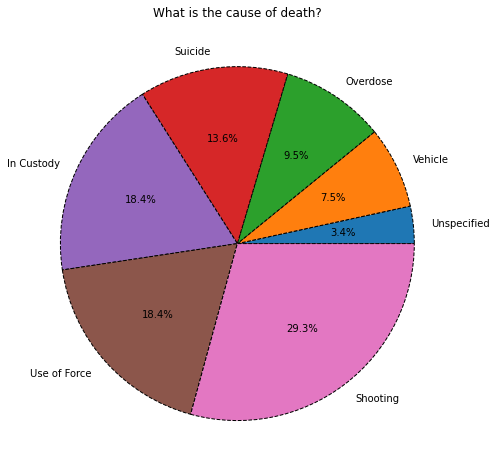

In [15]:
Deaths = BC_Data.groupby(['cause_death']).count()['date'].sort_values()
fig,ax=plt.subplots(figsize=(7,7))
ax.pie(
    Deaths,#['date'],
    labels=Deaths.index,
    textprops={'fontsize': 10},
#     colors=[Pie_Colors[i] for i in Armed.index],
    autopct='%1.1f%%',
    wedgeprops={"edgecolor":"k",'linewidth': 1,
                'linestyle': 'dashed',
               }
)
ax.set_title('What is the cause of death?')
plt.tight_layout()

## Step 4)

Geocode the addresses.

### Question 4)
Did the geocoder fail to recognize any of the locations?

In [16]:
BC_Data['latitude'] = np.nan
BC_Data['longitude'] = np.nan
BC_Data['geocoding_Notes'] = ''

geolocator = MapBox(api_key=api_key)

i = 0
for index, row in BC_Data.iterrows():
    attempt = ' '.join([row['address_intersection'], row['city_town'], row['prov'], row['postal_code'],'Canada'])
    try:
        g = geolocator.geocode(attempt,timeout=3)
        BC_Data.loc[BC_Data.index==index,['latitude','longitude']]=g.latitude,g.longitude
    except:
        Police_Killings.loc[Police_Killings['postal_code']==row['postal_code'],'geocoding_Notes']='Geocoding Failed'
        pass
    i += 1
save_to = 'Data/BC_Geocoded.csv'
BC_Data.to_csv(save_to)

Failures = BC_Data.loc[BC_Data['geocoding_Notes']=='Geocoding Failed']
print('Filed to Geocode: ',Failures.count()['date'], ' records.')
print('Geocoding Done')
print('File saved to: ',save_to)

Filed to Geocode:  0  records.
Geocoding Done
File saved to:  Data/BC_Geocoded.csv


## Step 5)

Inspect the results.  Create a web map to display the points.

### Question 5)
What spatial patterns stand out in the data set to you?

### Question 6)
Change the 'fill_color' parameter to 'red'.  Zoom to any specific area/region of interest (eg. Metro Vancouver, Northern BC, etc.).  Take a screenshot and submit it on canvas.

In [17]:
# Create a webmap centered on BC at zoom level 5 with a simple black/white map tile   
Map = folium.Map(location=[53, -125],zoom_start=5,tiles='Stamen Toner')

# loop through all records and plot them
for index, row in BC_Data.iterrows():
    # Cricle marker takes multiple arguments [latitude and longitude] are required.
    # The others are optoional for styling our map
    folium.CircleMarker(location=[row['latitude'],row['longitude']],
                        # Popup text to appear on click
                        popup=row['address_intersection']+' '+row['city_town'],
                        # fill color for circle
                        fill_color='blue',
                        # outline clor for circle
                        color='black'
                       ).add_to(Map)
    
Map.save('Data/PoliceViolenceIncidents_BC.html')
# print('Map Saved!')
    
# Display the map
Map